In [ ]:
N = 3   # Number of analogues to each query spectrum
TEST_SLICE = -1  # set to -1 for full set

# SSMMCS parameters
SIM_MAP_THESHOLD = 0.2
NORMALIZE_WEIGHTS = True
# Morgan fingerprint parameters
MORGAN_RADIUS = 9
NBITS = 2048
USE_FEATURES = False
FPTYPE = "bv"           # "bv" (bitvector) or "count"

# FMCS parameters
TIMEOUT = 360

In [3]:
import sys
import os

# Get path to the parent directory containing the package
MAIN_FOLDER = os.path.abspath(os.path.join(os.getcwd(), '../ms_chemical_space_explorer'))
DATA_FOLDER = "data"
PROCESSED_DATA_FOLDER = "processed"
FILENAME = "1000_test_spectra.mgf"
FILEPATH = os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER, FILENAME)
PICKLE = "pickle"

print(f"Adding to path: {MAIN_FOLDER}")
sys.path.append(MAIN_FOLDER)

Adding to path: g:\Dokumente\Studium\MMI\Master-Arbeit\Code\ms_chemical_space_explorer


In [ ]:
from rdkit import Chem
from ms_chemical_space_explorer.fragment_extractor import generate_mols_from_spectrum_query
import pickle
from ms_chemical_space_explorer.chemical_space_explorer import start_workflow
from tqdm.notebook import trange, tqdm

#Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)

In [89]:
from typing import Callable
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdFMCS

class MCSBenchmarkParams:
    """
    Class to hold parameters for MCS benchmarking.
    """
    def __init__(self, file_name: str = FILENAME):
        self.file_name = file_name
    
    def __str__(self) -> str:
        return f"file={self.file_name}"

class SSMMCSBenchmarkParams(MCSBenchmarkParams):
    """
    Class to hold parameters for SSMMCS benchmarking.
    """
    def __init__(self, file_name: str = FILENAME, sim_map_threshold: float = SIM_MAP_THESHOLD, normalize_weigths: bool = NORMALIZE_WEIGHTS, fingerprint_function: str = "MORGAN"):
        super().__init__(file_name=file_name)
        self.fingerprint_function = fingerprint_function.upper()
        self.sim_map_threshold = sim_map_threshold
        self.normalize_weights = normalize_weigths
        # MORGAN fingerprint parameters
        self.morgan_radius = MORGAN_RADIUS
        self.nbits = NBITS
        self.use_features = USE_FEATURES
        self.fp_type = FPTYPE
    
    def __str__(self) -> str:
        return f"SSMMCS-Benchmark_threshold={self.sim_map_threshold}_normalize={self.normalize_weights}_{self.get_fingerprint_params()}_{super().__str__()}"
    
    def get_fingerprint_params(self) -> str:
        param_string = f"fp={self.fingerprint_function}"
        
        if self.fingerprint_function == "MORGAN":
            return f"{param_string}_r={self.morgan_radius}_type={self.fp_type}_nBits={self.nbits}_useFeatures={self.use_features}"
        
        return f"{param_string}"
    
    def get_fingerprint_function(self, mol, atom_id, **kwargs) -> Callable:
        if self.fingerprint_function == "MORGAN":
            return SimilarityMaps.GetMorganFingerprint(
                mol, atom_id, 
                radius=self.morgan_radius, 
                fpType=self.fp_type, 
                nBits=self.nbits, 
                useFeatures=self.use_features, 
                **kwargs
            )
        elif self.fingerprint_function == "AP":
            return SimilarityMaps.GetAPFingerprint(
                mol, atom_id, 
                **kwargs
            )
        elif self.fingerprint_function == "TT":
            return SimilarityMaps.GetTTFingerprint(
                mol, atom_id, 
                **kwargs
            )
        elif self.fingerprint_function == "RDK":
            return SimilarityMaps.GetRDKFingerprint(
                mol, atom_id, 
                **kwargs
            )
        else:
            raise ValueError(f"Unknown fingerprint function: {self.fingerprint_function}")
    
class FMCSBenchmarkParams(MCSBenchmarkParams):
    """
    Class to hold parameters for FMCS benchmarking.
    """
    def __init__(self, file_name=FILENAME, params: rdFMCS.MCSParameters = rdFMCS.MCSParameters()):
        super().__init__(file_name=file_name)
        self.params = params
    
    def __str__(self) -> str:
        atom_compare_params = self.get_atom_compare_parameters()
        bond_compare_params = self.get_bond_compare_parameters()
        base_params = self.get_base_parameters()
        return f"FMCS-Benchmark_{base_params}_{atom_compare_params}_{bond_compare_params}_{super().__str__()}"
    
    def get_atom_compare_parameters(self) -> str:
        acp = self.params.AtomCompareParameters
        return f"ACCRO={int(acp.CompleteRingsOnly)}_ACRRO={int(acp.RingMatchesRingOnly)}_MCT={int(acp.MatchChiralTag)}_MFC={int(acp.MatchFormalCharge)}_MI={int(acp.MatchIsotope)}_MV={int(acp.MatchValences)}_MD={acp.MaxDistance}"
    
    def get_bond_compare_parameters(self) -> str:
        bcp = self.params.BondCompareParameters
        return f"BCCRO={int(bcp.CompleteRingsOnly)}_BCRRO={int(bcp.RingMatchesRingOnly)}_MFR={int(bcp.MatchFusedRings)}_MFRS={int(bcp.MatchFusedRingsStrict)}_MS={int(bcp.MatchStereo)}"

    def get_base_parameters(self) -> str:
        params = self.params
        return f"AT={int(params.AtomTyper)}_BT={int(params.BondTyper)}_TO={params.Timeout}_SA={int(params.StoreAll)}_MB={int(params.MaximizeBonds)}_TH={params.Threshold}"

class ChemSpaceExplorerBenchmarkParams:
    """
    Class to hold parameters for benchmarking on ChemSpaceExplorer results.
    """
    def __init__(self, n: int = N, test_slice: int = TEST_SLICE, method_params: MCSBenchmarkParams = SSMMCSBenchmarkParams()):
        self.n = n
        self.test_slice = test_slice
        self.method_params = method_params
    
    def __str__(self) -> str:
        if self.test_slice >= 0:
            return f"CSE_n={self.n}_slice={self.test_slice}-{self.method_params}"
        
        return f"CSE_n={self.n}-{self.method_params}"

# Chemspace Explorer Initialization

In [4]:
from ms_chemical_space_explorer.chemical_space_explorer import spectra_importer

query_spectra = spectra_importer(FILEPATH)

Processing spectra: 100%|██████████| 1000/1000 [00:04<00:00, 240.96it/s]


In [5]:
def analogue_search(n: int = 2):
    file = os.path.join(PICKLE, f'results_n={n}.pkl')
    try:
        with open(file, 'rb') as f:
            analogues = pickle.load(f)
            print(f"Loaded analogues from {file}")
    
    except FileNotFoundError:
        explorer = start_workflow(os.path.abspath(os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER)))
        analogues = explorer.analogue_search(query_spectra, n=n)
        
        with open(file, 'wb') as f:
            pickle.dump(analogues, f)
        print(f"Analogues saved to {file}")
        
    return analogues

In [6]:
import pandas as pd

analogues_df = analogue_search(n=N)

Loaded analogues from pickle\results_n=3.pkl


In [7]:
def generate_query_mols():
    file = os.path.join(PICKLE, f'{len(query_spectra)}_query_mols_for_{FILENAME}.pkl')
    query_mols = []
    try:
        with open(file, 'rb') as f:
            query_mols = pickle.load(f)
            print(f"Loaded {len(query_mols)} query mols from {file}")
    
    except FileNotFoundError:
        for query_id, query_spectrum in tqdm(enumerate(query_spectra), desc="Generating query mols...", unit="mols"):
            mol = Chem.MolFromSmiles(query_spectrum.metadata["smiles"])
            query_mols.append(mol)
        
        with open(file, 'wb') as f:
            pickle.dump(query_mols, f)
        print(f"{len(query_mols)} query mols saved to {file}.")
        
    return query_mols

def generate_analogue_mols(dataFrame: pd.DataFrame):
    file = os.path.join(PICKLE, f'n={N}_analogue_dataframe_with_{len(query_spectra)*N}_mols_for_{FILENAME}.pkl')
    try:
        with open(file, 'rb') as f:
            dataFrame = pickle.load(f)
            print(f"Loaded dataframe with {len(dataFrame)} analogues from {file}")
    
    except FileNotFoundError:
        for idx, row in tqdm(dataFrame.iterrows(), desc="Adding mols to analogue dataframe...", unit="mols"):
            mol = Chem.MolFromSmiles(row["smiles"])
            dataFrame.loc[idx, "mol"] = mol
        
        with open(file, 'wb') as f:
            pickle.dump(dataFrame, f)
        print(f"Dataframe with {len(dataFrame)} analogue mols saved to {file}.")
        
    return dataFrame

In [8]:
if(TEST_SLICE > 0):
    query_mols = generate_query_mols()[:TEST_SLICE]
else:
    query_mols = generate_query_mols()

analogues_df = generate_analogue_mols(analogues_df)

Loaded 603 query mols from pickle\603_query_mols_for_1000_test_spectra.mgf.pkl
Loaded dataframe with 1806 analogues from pickle\n=3_analogue_dataframe_with_1809_mols_for_1000_test_spectra.mgf.pkl


In [9]:
# sanity check
if(TEST_SLICE > 0):
    assert len(query_mols[:TEST_SLICE]) == len(query_spectra[:TEST_SLICE])
else:
    assert len(query_mols) == len(query_spectra)
assert analogues_df["query_spectrum_id"].nunique() == len(query_spectra)
assert len(analogues_df) >= len(query_spectra)
assert len(analogues_df) <= len(query_spectra) * N

len(query_spectra) * N

1809

In [10]:
def get_query_analogues(query_id: int):
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["mol"].tolist()

In [ ]:
from typing import Callable

def benchmark(query_mols, method_name: str, param_string: str, params, method: Callable):
    filename = f'{len(query_mols)}_{method_name}_results-N={N}-File={FILENAME}__PARAMS__{param_string}.csv'
    # Sanitize the whole filename again just to be safe
    filename = sanitize_filename(filename)
    file = os.path.join(DATA_FOLDER, filename)

    if os.path.exists(file):
        df = pd.read_csv(file)
        print(f"Loaded {len(df)} {method_name} results from {file}.")
    else:
        df = method(query_mols, params)
        
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(file), exist_ok=True)
        # Save CSV once after all processing is complete
        df.to_csv(file, index=False)
        print(f"Saved {len(df)} {method_name} results to {file}.")
    
    return df

def sanitize_filename(filename):
    """Replace invalid filename characters with underscores."""
    # Characters not allowed in Windows filenames
    invalid_chars = r'<>:"/\|?*(),'
    for char in invalid_chars:
        filename = filename.replace(char, '___')
    return filename

# FMCS

In [ ]:
import time

def fmcs_params_to_string(params: rdFMCS.MCSParameters):
    """Convert MCSParameters to a detailed string representation."""
    attributes = []
    
    # Core parameters
    attributes.append(f"AtomTyper={params.AtomTyper}-")
    attributes.append(f"BondTyper={params.BondTyper}-")
    attributes.append(f"Timeout={params.Timeout}-")
    
    # AtomCompareParameters
    acp = params.AtomCompareParameters
    attributes.append(f"RingMatchesRingOnly={acp.RingMatchesRingOnly}-")
    attributes.append(f"CompleteRingsOnly={acp.CompleteRingsOnly}-")
    attributes.append(f"MatchChiralTag={acp.MatchChiralTag}-")
    attributes.append(f"MatchFormalCharge={acp.MatchFormalCharge}-")
    
    # Additional parameters
    attributes.append(f"MaximizeBonds={params.MaximizeBonds}-")
    attributes.append(f"Threshold={params.Threshold}")
    
    return "".join(attributes)

def benchmark_fmcs(query_mols, params: rdFMCS.MCSParameters):
    fmcs_df = pd.DataFrame(columns=["query_id", "matched", "failed", "time", 
                                "mcs_size", "mcs_smarts", "query_match", "degenerate_smarts"])

    for query_id, query_mol in tqdm(enumerate(query_mols), total=len(query_mols), desc="Benchmarking FMCS"):
        try:
            query_analogues = get_query_analogues(query_id)
            if len(query_analogues) < 2:
                print(f"Skipping query {query_id} due to insufficient number of analogues!")
                continue
            
            start_time = time.time()
            fmcs = rdFMCS.FindMCS(query_analogues, params)
            elapsed_time = time.time() - start_time
            
            matched = False
            query_match = None
            smartsString = None
            degenerate_smarts = None
            
            if params.StoreAll and len(fmcs.degenerateSmartsQueryMolDict) > 0:
                degenerate_smarts = []
                for smarts, mcs in fmcs.degenerateSmartsQueryMolDict.items():
                    # only update match result, if we haven't found a match yet
                    if not matched:
                        degenerate_mcs_match = query_mol.GetSubstructMatch(mcs)
                        degenerate_mcs_matched = len(degenerate_mcs_match) > 0
                        
                        if degenerate_mcs_matched:
                            query_match = degenerate_mcs_match
                            smartsString = smarts
                            matched = True
                    
                    # only store additional smarts to the matched smarts
                    if smartsString != smarts:
                        degenerate_smarts.append(smarts)
                        
            else:
                query_match = query_mol.GetSubstructMatch(fmcs.queryMol)
                matched = len(query_match) > 0
                smartsString = fmcs.smartsString
            
            aborted = fmcs.canceled
            
            # Save data as a row
            new_row = {
                "query_id": query_id,
                "matched": matched,
                "failed": aborted,
                "time": elapsed_time,
                "mcs_size": fmcs.numAtoms,
                "mcs_smarts": smartsString,
                "query_match": query_match if matched else None,
                "degenerate_smarts": degenerate_smarts
            }
            fmcs_df = pd.concat([fmcs_df, pd.DataFrame([new_row])], ignore_index=True)
        except Exception as e:
            print(f"Error processing query {query_id}: {e}")
            continue
    
    return fmcs_df

In [13]:
params = rdFMCS.MCSParameters()
params.AtomTyper = rdFMCS.AtomCompare.CompareElements
params.BondTyper = rdFMCS.BondCompare.CompareOrderExact
params.AtomCompareParameters.RingMatchesRingOnly = True
params.Timeout = TIMEOUT

# Create sanitized parameter string first
param_string = fmcs_params_to_string(params)
fmcs_df = benchmark(query_mols, "FMCS", param_string, params, method=benchmark_fmcs)

Benchmarking FMCS:   0%|          | 0/603 [00:00<?, ?it/s]

C:\Users\kevin\AppData\Local\Temp\ipykernel_13752\3115941680.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fmcs_df = pd.concat([fmcs_df, pd.DataFrame([new_row])], ignore_index=True)


Skipping query 564 due to insufficient number of analogues!


AssertionError: Expected 603 results, got 602.

In [ ]:
fmcs_df

,query_id,matched,aborted,time,mcs_size,mcs_smarts,query_match
0,0,True,False,0.005001,42,[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,1,True,False,0.011000,10,[#8&!R]-[#6]1-[#6](-[#8&!R])-[#8]-[#6]-[#6](-[...,"(7, 8, 9, 30, 10, 18, 25, 31, 19, 26)"
2,2,True,False,0.723003,22,[#8&!R]-[#6]1-[#6](-[#8&!R])-[#6](-[#8&!R])-[#...,"(8, 7, 5, 9, 6, 4, 15, 10, 3, 16, 17, 18, 19, ..."
3,3,True,False,0.001000,20,[#6]1-[#6]2:[#6](-[#8&!R]):[#6]:[#6](:[#6]:[#6...,"(2, 3, 1, 4, 10, 12, 0, 5, 6, 9, 11, 13, 7, 14..."
4,4,False,False,0.009999,15,[#6]1-[#6]-[#6]-[#6]-[#6]2-[#6]-1(-[#6]-[#6]-[...,None
...,...,...,...,...,...,...,...
96,96,False,False,0.000000,17,[#6&!R]-[#6]1-[#6]-[#6](-[#7](-[#7]=1)-[#6]1:[...,None
97,97,False,False,0.003002,11,[#6]1:[#6](-[#8&!R]-[#6&!R]):[#6]:[#6]:[#6](:[...,None
98,98,False,False,0.005004,17,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#8&R]-[#6&R]...,None
99,99,False,False,0.033000,21,[#6&!R]-[#6&!R](-[#7&!R]-[#6&!R](=[#8&!R])-[#7...,None


# SSMMCS

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps

def MorganWrapper(mol, atomId, **kwargs):
    return SimilarityMaps.GetMorganFingerprint(mol, atomId, radius=MORGAN_RADIUS, fpType=FPTYPE, nBits=NBITS, useFeatures=USE_FEATURES, **kwargs)

def get_stacked_sim_map_fragments_and_weights(
    mols: list[Chem.Mol],
    fp_function: callable = SimilarityMaps.GetMorganFingerprint,
    similarity_threshold: float = 0.2,
    normalize_stacked_weights: bool = True,
) -> tuple[list[Chem.Mol], list[list[float]]]:

    stacked_weights = []
    all_analogue_fragments = []

    for ref_mol in mols:
        ref_mol_smiles = Chem.MolToSmiles(ref_mol)
        ref_mol_stacked_weights = [0] * ref_mol.GetNumAtoms()
        for probe_mol in mols:
            probe_mol_smiles = Chem.MolToSmiles(probe_mol)
            # Skip if comparing molecule to itself
            if probe_mol_smiles == ref_mol_smiles:
                continue

            # extract similarity weights for the reference molecule
            sim_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(probe_mol, ref_mol, fp_function)
            sim_weights, _ = SimilarityMaps.GetStandardizedWeights(sim_weights)
            
            assert len(sim_weights) == ref_mol.GetNumAtoms(), "Length of sim_weights does not match number of atoms in reference molecule."
            # stack the weights
            ref_mol_stacked_weights = [ref_mol_stacked_weights[i] + sim_weights[i] for i in range(ref_mol.GetNumAtoms())]
        
        if(normalize_stacked_weights):
            ref_mol_stacked_weights, _ = SimilarityMaps.GetStandardizedWeights(ref_mol_stacked_weights)
        
        stacked_weights.append(ref_mol_stacked_weights)
        
        # Extract fragments from the reference molecule using the similarity weights
        analogue_fragments = extract_sim_map_fragments_from_mol(ref_mol, ref_mol_stacked_weights, similarity_threshold)
        all_analogue_fragments.extend(analogue_fragments)
    
    return all_analogue_fragments, stacked_weights

def find_SSMMCS_and_SSMMSS(
    mols: list[Chem.Mol], substruct_candidates: list[Chem.Mol], min_num_atoms: int = 2
    ) -> tuple[Chem.Mol | None, Chem.Mol | None]:
    
    common_substructs = []
    unique_smiles = set()
    mcs_id = -1
    mcs_size = 0
    mss = None
    mss_size = 0
    
    for substruct in substruct_candidates:
        num_Atoms = substruct.GetNumAtoms()
        
        # skip substructs below atom threshold
        if num_Atoms < min_num_atoms:
            continue
        
        # skip duplicates
        smiles = Chem.MolToSmiles(substruct)
        if smiles in unique_smiles:
            continue
        unique_smiles.add(smiles)
        
        # find the maximum stacked substructure (MSS)
        if num_Atoms > mss_size:
            mss = substruct
            mss_size = num_Atoms
        
        # find the maximum common substructure (MCS)
        is_common = True
        for analogue in mols:
            if len(analogue.GetSubstructMatch(substruct)) <= 0:
                is_common = False
                break
        
        if not is_common:
            continue
        common_substructs.append(substruct)
        
        if num_Atoms > mcs_size:
            mcs_id = len(common_substructs) - 1
            mcs_size = num_Atoms
        
        # if MSS and MCS are the same size, update MSS to MCS
        if num_Atoms == mss_size:
            mss = common_substructs[mcs_id]
        
    if mcs_id < 0:
        mcs = None
    else:
        mcs = common_substructs[mcs_id]

    return mcs, mss

def extract_sim_map_fragments_from_mol(
    mol: Chem.Mol, similarity_weights: list[float], similarity_threshold: float
) -> list[Chem.Mol]:

    visited = set()
    fragment_mols = []

    # Iterate through all atoms to find connected_atoms
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        if atom_idx not in visited and similarity_weights[atom_idx] >= similarity_threshold:
            connected_atoms = find_connected_atoms_recursive(
                atom_idx, visited, mol, similarity_weights, similarity_threshold
            )
            if connected_atoms:
                # Create a new molecule for this connected_atoms
                fragment = Chem.RWMol(mol)

                # Create a map of atoms to remove (those not in connected_atoms)
                atoms_to_remove = set(range(mol.GetNumAtoms())) - connected_atoms

                # Remove atoms not in connected_atoms (remove in reverse order to preserve indices)
                for remove_idx in sorted(atoms_to_remove, reverse=True):
                    fragment.RemoveAtom(remove_idx)

                # Convert to regular molecule and add to list
                fragment_mols.append(fragment.GetMol())

    return fragment_mols

def find_connected_atoms_recursive(
    atom_idx: int, visited: set[int], mol: Chem.Mol, similarity_weights: list[float], similarity_threshold: float
) -> set[int]:
    if atom_idx in visited or similarity_weights[atom_idx] < similarity_threshold:
        return set()

    atoms = {atom_idx}
    visited.add(atom_idx)

    # Get current atom object
    atom = mol.GetAtomWithIdx(atom_idx)

    # Iterate through bonds to neighboring atoms
    for bond in atom.GetBonds():
        # Get the neighboring atom's index
        neighbor_idx = bond.GetBeginAtomIdx() if bond.GetEndAtomIdx() == atom_idx else bond.GetEndAtomIdx()

        if similarity_weights[neighbor_idx] >= similarity_threshold:
            atoms.update(
                find_connected_atoms_recursive(neighbor_idx, visited, mol, similarity_weights, similarity_threshold)
            )

    return atoms

In [ ]:
def FindSSMMCS(query_analogues, fp_function, similarity_threshold, normalize_stacked_weights):
    all_analogue_fragments, _ = get_stacked_sim_map_fragments_and_weights(
        query_analogues, fp_function, similarity_threshold, normalize_stacked_weights
    )
    
    return find_SSMMCS_and_SSMMSS(
        query_analogues, all_analogue_fragments, min_num_atoms=2
    )

In [ ]:
import time

def benchmark_ssmmcs(query_mols, params):
    ssmmcs_df = pd.DataFrame(columns=["query_id", "matched_mcs", "matched_mss", "failed", "time", 
                                "mcs_size", "mcs_smarts", "mss_size", "mss_smarts"])

    for query_id, query_mol in tqdm(enumerate(query_mols), total=len(query_mols), desc="Benchmarking SSMMMCS"):
        try:
            query_analogues = get_query_analogues(query_id)
            if len(query_analogues) < 2:
                print(f"Skipping query {query_id} due to insufficient number of analogues!")
                continue
            start_time = time.time()
            mcs, mss = FindSSMMCS(query_analogues, MorganWrapper, SIM_MAP_THESHOLD, NORMALIZE_WEIGHTS)
            elapsed_time = time.time() - start_time
        
            if mcs is None:
                matched_mcs = False
                query_match_mcs = None
                mcs_size = 0
                mcs_smarts = ""
            else:
                query_match_mcs = query_mol.GetSubstructMatch(mcs)
                matched_mcs = len(query_match_mcs) > 0
                mcs_size = mcs.GetNumAtoms()
                mcs_smarts = Chem.MolToSmarts(mcs)
            
            if mss is None:
                matched_mss = False
                query_match_mss = None
                mss_size = 0
                mss_smarts = ""
            else:
                query_match_mss = query_mol.GetSubstructMatch(mss)
                matched_mss = len(query_match_mss) > 0
                mss_size = mss.GetNumAtoms()
                mss_smarts = Chem.MolToSmarts(mss)
            
            # Save data as a row
            new_row = {
                "query_id": query_id,
                "matched_mcs": matched_mcs,
                "matched_mss": matched_mss,
                "failed": not matched_mcs and not matched_mss,
                "time": elapsed_time,
                "mcs_size": mcs_size,
                "mcs_smarts": mcs_smarts,
                "mss_size": mss_size,
                "mss_smarts": mss_smarts,
                "query_match_mcs": query_match_mcs,
                "query_match_mss": query_match_mss,
            }
            ssmmcs_df = pd.concat([ssmmcs_df, pd.DataFrame([new_row])], ignore_index=True)
        except Exception as e:
            print(f"Error processing query {query_id}: {e}")
            continue
    
    return ssmmcs_df

In [ ]:
ssmmcs_df = benchmark(query_mols, method_name= "SSMMCS", param_string="", params=None, method=benchmark_ssmmcs)
ssmmcs_df

Loaded 101 SSMMCS results from data\101_SSMMCS_results-N=3-File=1000_test_spectra.mgf__PARAMS__.csv.


,query_id,matched_mcs,matched_mss,time,mcs_size,mcs_smarts,mss_size,mss_smarts,query_match_mcs,query_match_mss
0,0,True,False,0.246000,41,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,45,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",()
1,1,True,True,0.115997,11,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,32,[#6]-[#6]-[#6](=[#8])-[#8]-[#6@@H]1-[#6@H](-[#...,"(32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43)","(3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 25, 26, ..."
2,2,True,True,0.071999,5,[#6]-[#6]-[#8]-[#6]:[#6],18,[#6]-[#6]1:[#6]:[#6](:[#6](:[#6]:[#8]:1):[#6]:...,"(4, 16, 17, 18, 19)","(23, 22, 24, 25, 27, 20, 18, 17, 16, 4, 3, 1, ..."
3,3,True,True,0.050997,19,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,19,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,"(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
4,4,False,False,0.030998,10,[#6]1-[#6](-[#6])(-[#6](=[#8])-[#8])-[#6]-[#6]...,10,[#6]1-[#6](-[#6])(-[#6](=[#8])-[#8])-[#6]-[#6]...,(),()
...,...,...,...,...,...,...,...,...,...,...
96,96,False,False,0.025998,13,[#6]-[#7](-[#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#...,13,[#6]-[#7](-[#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#...,(),()
97,97,False,False,0.020999,11,[#6]1:[#6](-[#8]-[#6]):[#6]:[#6](-[#8]):[#6](-...,11,[#6]1:[#6](-[#8]-[#6]):[#6]:[#6](-[#8]):[#6](-...,(),()
98,98,False,False,0.036999,11,[#8]-[#6@@H](-[#6]1:[#6]:[#6]:[#6](-[#8]):[#6]...,11,[#8]-[#6@@H](-[#6]1:[#6]:[#6]:[#6](-[#8]):[#6]...,(),()
99,99,False,False,0.058002,13,[#8]=[#6](-[#8])-[#6@H]-[#7]-[#6](=[#8])-[#7]1...,30,[#8]=[#6](-[#8])-[#6@H](-[#6]-[#6]1:[#6]:[#6]:...,(),()


In [ ]:
fmcs_df["time"].sum(), ssmmcs_df["time"].sum()

(487.47900223731995, 6.50688910484314)

# Overall Benchmark results

In [ ]:
fmcs_df.mcs_size.mean(), ssmmcs_df.mcs_size.mean(), fmcs_df.mcs_size.std(), ssmmcs_df.mcs_size.std()

(16.514851485148515, 11.009900990099009, 9.712480487894057, 8.36958188860704)

In [ ]:
ssmmcs_df.mss_size.mean(), ssmmcs_df.mss_size.std()

(18.10891089108911, 12.509916858316053)

In [ ]:
fmcs_df.matched.sum()

39

In [ ]:
fmcs_df[fmcs_df["matched"] == True]

,query_id,matched,aborted,time,mcs_size,mcs_smarts,query_match
0,0,True,False,0.005001,42,[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,1,True,False,0.011000,10,[#8&!R]-[#6]1-[#6](-[#8&!R])-[#8]-[#6]-[#6](-[...,"(7, 8, 9, 30, 10, 18, 25, 31, 19, 26)"
2,2,True,False,0.723003,22,[#8&!R]-[#6]1-[#6](-[#8&!R])-[#6](-[#8&!R])-[#...,"(8, 7, 5, 9, 6, 4, 15, 10, 3, 16, 17, 18, 19, ..."
3,3,True,False,0.001000,20,[#6]1-[#6]2:[#6](-[#8&!R]):[#6]:[#6](:[#6]:[#6...,"(2, 3, 1, 4, 10, 12, 0, 5, 6, 9, 11, 13, 7, 14..."
5,5,True,False,0.002000,10,[#16&!R](=[#8&!R])(=[#8&!R])-[#6]1:[#6]:[#6]:[...,"(13, 14, 15, 16, 17, 22, 18, 21, 19, 20)"
11,11,True,False,0.000999,28,[#6&!R]-[#6&!R]-[#7&!R](-[#6&!R]-[#6&!R])-[#6&...,"(0, 1, 2, 3, 5, 4, 6, 7, 8, 28, 9, 27, 23, 10,..."
12,12,True,False,0.001001,8,[#6&!R]-[#6&!R]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,"(7, 6, 3, 2, 4, 1, 5, 0)"
15,15,True,False,0.001002,9,[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6&!R](=[#...,"(0, 1, 5, 2, 4, 3, 6, 7, 8)"
17,17,True,False,0.203995,17,[#6&!R]-[#6&R]-[#6&R](-[#6&R]-[#6&R]-[#6&R])-[...,"(0, 1, 37, 35, 38, 33, 39, 3, 40, 48, 41, 46, ..."
19,19,True,False,0.000997,17,[#6]1:[#7]:[#6]2:[#6](:[#6]:[#7]:1):[#7]:[#6]:...,"(17, 16, 18, 15, 1, 2, 5, 3, 4, 6, 13, 7, 11, ..."


In [ ]:
ssmmcs_df[ssmmcs_df["matched_mcs"] == True]

,query_id,matched_mcs,matched_mss,time,mcs_size,mcs_smarts,mss_size,mss_smarts,query_match_mcs,query_match_mss
0,0,True,False,0.246000,41,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,45,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",()
1,1,True,True,0.115997,11,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,32,[#6]-[#6]-[#6](=[#8])-[#8]-[#6@@H]1-[#6@H](-[#...,"(32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43)","(3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 25, 26, ..."
2,2,True,True,0.071999,5,[#6]-[#6]-[#8]-[#6]:[#6],18,[#6]-[#6]1:[#6]:[#6](:[#6](:[#6]:[#8]:1):[#6]:...,"(4, 16, 17, 18, 19)","(23, 22, 24, 25, 27, 20, 18, 17, 16, 4, 3, 1, ..."
3,3,True,True,0.050997,19,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,19,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,"(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
5,5,True,False,0.051002,8,[#16]-[#6]1:[#6]:[#6]:[#6](-[#6]):[#6]:[#6]:1,18,[#6]-[#6]1:[#6]:[#6]:[#6](-[#16](=[#8])(=[#8])...,"(13, 16, 17, 18, 19, 20, 21, 22)",()
...,...,...,...,...,...,...,...,...,...,...
89,89,True,True,0.015999,7,[#6]:[#6]:[#6](-[#8]):[#6]:[#6]-[#8],7,[#6]:[#6]:[#6](-[#8]):[#6]:[#6]-[#8],"(4, 3, 8, 9, 7, 6, 10)","(4, 3, 8, 9, 7, 6, 10)"
90,90,True,False,0.058000,9,[#6]-[#6](=[#8])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,26,[#6]-[#6](-[#6])=[#6]-[#6]-[#6]1:[#6](-[#8]):[...,"(16, 14, 15, 11, 9, 7, 6, 13, 12)",()
92,92,True,False,0.061998,3,[#6]:[#6]:[#6],11,[#8]1-[#6@H]-[#6@@H](-[#6@H](-[#6@@H](-[#6@H]-...,"(1, 3, 2)",()
93,93,True,False,0.053999,7,[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,18,[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]:[#6](-[#6](=[...,"(20, 21, 22, 23, 24, 28, 29)",()


In [ ]:
ssmmcs_df.matched_mcs.sum(), ssmmcs_df.matched_mss.sum()

(61, 25)

In [ ]:
# show all fmcs queries where ssmmcs failed
fmcs_df[(fmcs_df["matched"] == True) & (ssmmcs_df["matched_mcs"] == False)]

,query_id,matched,aborted,time,mcs_size,mcs_smarts,query_match
12,12,True,False,0.001001,8,[#6&!R]-[#6&!R]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,"(7, 6, 3, 2, 4, 1, 5, 0)"
37,37,True,False,0.000999,2,[#6&!R]-[#6&!R],"(0, 1)"


In [ ]:
# and vice versa
ssmmcs_df[(ssmmcs_df["matched_mcs"] == True) & (fmcs_df["matched"] == False)]

,query_id,matched_mcs,matched_mss,time,mcs_size,mcs_smarts,mss_size,mss_smarts,query_match_mcs,query_match_mss
7,7,True,False,0.041998,6,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,9,[#6]:[#6]1:[#6]:[#8]:[#6]:[#6](-[#6]):[#6]:1=[#8],"(1, 2, 3, 4, 29, 30)",()
9,9,True,False,0.038998,2,[#6]=[#8],15,[#8]=[#6](-[#7]-[#6](:[#6]):[#6])-[#6](:[#6]:[...,"(6, 8)",()
14,14,True,True,0.013998,9,[#6](-[#6@H](-[#6@H](-[#6@H])-[#8])-[#8])-[#8]...,9,[#6](-[#6@H](-[#6@H](-[#6@H])-[#8])-[#8])-[#8]...,"(5, 4, 3, 2, 13, 12, 7, 8, 9)","(5, 4, 3, 2, 13, 12, 7, 8, 9)"
16,16,True,False,0.070003,2,[#6]:[#6],26,[#8]=[#6](-[#7]-[#6]1:[#7]:[#6]:[#6]:[#16]:1)-...,"(3, 4)",()
23,23,True,False,0.068999,3,[#6]-[#6]-[#8],7,[#6]-[#6](-[#6])=[#6]-[#6](-[#8])-[#6],"(6, 7, 9)",()
25,25,True,False,0.055002,2,[#6]=[#8],27,[#8]=[#6](-[#7]-[#6]-[#6]-[#6]1:[#6]:[#7H]:[#6...,"(16, 17)",()
27,27,True,True,0.033001,16,[#8]-[#6@@H]1-[#6@@H](-[#6]-[#8]-[#15](-[#8])(...,16,[#8]-[#6@@H]1-[#6@@H](-[#6]-[#8]-[#15](-[#8])(...,"(16, 7, 8, 10, 11, 12, 14, 15, 13, 9, 5, 6, 17...","(16, 7, 8, 10, 11, 12, 14, 15, 13, 9, 5, 6, 17..."
33,33,True,False,0.026000,2,[#6]-[#17],9,[#8]-[#6](:[#6]:[#6](-[#17]):[#6]-[#17]):[#6]-...,"(4, 5)",()
39,39,True,False,0.022000,4,[#6]:[#6](:[#6])-[#8],9,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,"(7, 10, 8, 9)",()
41,41,True,True,0.031004,14,[#7]-[#6@@H]1-[#8]-[#6@H](-[#6]-[#8]-[#15](=[#...,14,[#7]-[#6@@H]1-[#8]-[#6@H](-[#6]-[#8]-[#15](=[#...,"(4, 5, 9, 8, 10, 11, 12, 13, 14, 15, 7, 16, 6,...","(4, 5, 9, 8, 10, 11, 12, 13, 14, 15, 7, 16, 6,..."


In [ ]:
# show the mcs size difference between ssmmcs and fmcs
mask = (ssmmcs_df["matched_mcs"] == True) & (fmcs_df["matched"] == True)
botch_mathed = ssmmcs_df.loc[mask, "mcs_size"] - fmcs_df.loc[mask, "mcs_size"]
botch_mathed.mean(), botch_mathed.std(), botch_mathed.min(), botch_mathed.max()

(-4.4324324324324325, 4.585851069325086, -17, 1)

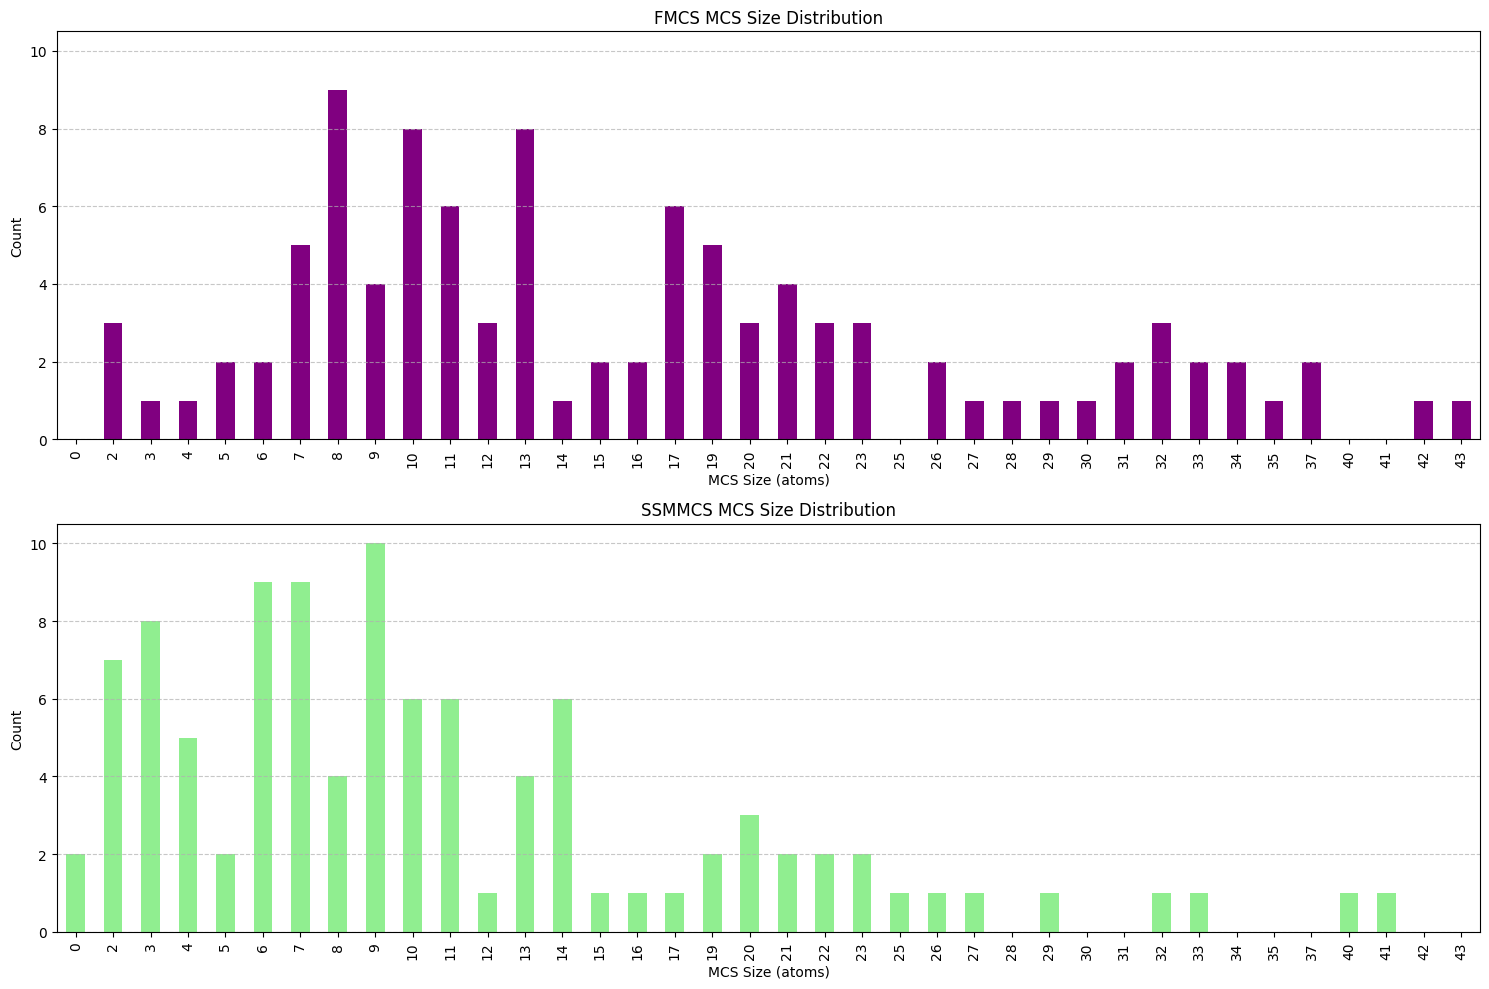

In [ ]:
from turtle import color
import matplotlib.pyplot as plt
import pandas as pd

# Get all unique MCS sizes that appear in either dataframe
all_sizes = sorted(set(fmcs_df["mcs_size"].unique()) | set(ssmmcs_df["mcs_size"].unique()))

# Create Series with counts for each size, including zeros for missing values
fmcs_counts = fmcs_df["mcs_size"].value_counts().reindex(all_sizes, fill_value=0).sort_index()
ssmmcs_counts = ssmmcs_df["mcs_size"].value_counts().reindex(all_sizes, fill_value=0).sort_index()

# Calculate the maximum count value across both distributions
max_count = max(fmcs_counts.max(), ssmmcs_counts.max())

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot FMCS distribution with consistent x-axis
fmcs_counts.plot(
    kind="bar",
    ax=ax1,
    title="FMCS MCS Size Distribution",
    color='purple',  # Set color for FMCS bars
)
ax1.set_ylim(0, max_count * 1.05)  # Add 5% padding
ax1.set_xlabel("MCS Size (atoms)")
ax1.set_ylabel("Count")
ax1.grid(axis='y', linestyle='--', alpha=0.7)  # Add y-axis grid lines

# Plot SSMMCS distribution with consistent x-axis
ssmmcs_counts.plot(
    kind="bar", 
    ax=ax2,
    title="SSMMCS MCS Size Distribution",
    color='lightgreen',  # Set color for SSMMCS bars
)
ax2.set_ylim(0, max_count * 1.05)  # Add 5% padding
ax2.set_xlabel("MCS Size (atoms)")
ax2.set_ylabel("Count")
ax2.grid(axis='y', linestyle='--', alpha=0.7)  # Add y-axis grid lines

plt.tight_layout()
plt.show()

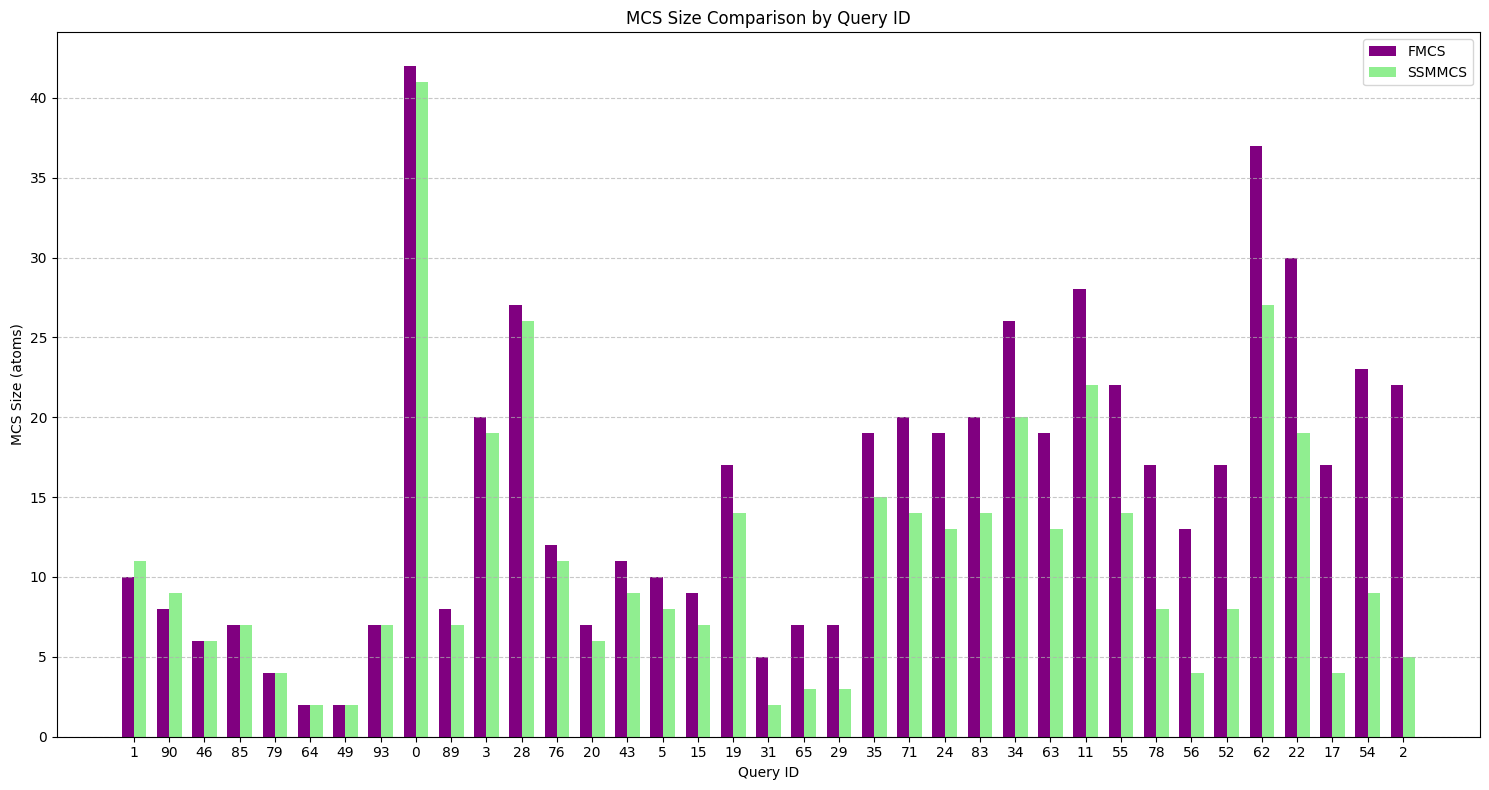

In [ ]:
from matplotlib.offsetbox import OffsetImage
import matplotlib.pyplot as plt
import numpy as np

# 1. First get all query IDs where both methods found a match
mask = (ssmmcs_df["matched_mcs"] == True) & (fmcs_df["matched"] == True)
matched_query_ids = fmcs_df[mask]["query_id"].unique()

# 2. Create a dataframe to hold the comparison data
comparison_df = pd.DataFrame({
    'query_id': [],
    'fmcs_size': [],
    'ssmmcs_size': []
})

# 3. Populate the comparison dataframe
for qid in matched_query_ids:
    fmcs_size = fmcs_df[fmcs_df["query_id"] == qid]["mcs_size"].values[0]
    ssmmcs_size = ssmmcs_df[ssmmcs_df["query_id"] == qid]["mcs_size"].values[0]
    comparison_df = pd.concat([comparison_df, pd.DataFrame({
        'query_id': [qid],
        'fmcs_size': [fmcs_size],
        'ssmmcs_size': [ssmmcs_size],
        'difference': [ssmmcs_size - fmcs_size]
    })], ignore_index=True)

comparison_df = comparison_df.sort_values('difference', ascending=False)

# Setting up the bar chart with side-by-side bars
bar_width = 0.35
x = np.arange(len(comparison_df))

fig, ax = plt.subplots(figsize=(15, 8))

# Creating the bars
bar1 = ax.bar(x - bar_width/2, comparison_df['fmcs_size'], bar_width, label='FMCS', color='purple')
bar2 = ax.bar(x + bar_width/2, comparison_df['ssmmcs_size'], bar_width, label='SSMMCS', color='lightgreen')

# Add labels, title and legend
ax.set_xlabel('Query ID')
ax.set_ylabel('MCS Size (atoms)')
ax.set_title('MCS Size Comparison by Query ID')
ax.set_xticks(x, [f'{int(qid)}' for qid in comparison_df['query_id']])
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add y-axis grid lines

ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
benchmark_df = pd.DataFrame(columns=["method",
                                     "matched_ratio", 
                                     "avg_mcs_size", 
                                     "computation_time", 
                                     "matched_query_ids", 
                                     "aborted_query_ids", 
                                     "mcs_sizes",
                                     "mcs_matches"])

csv_file = os.path.join(DATA_FOLDER, f'benchmark_results_for_{FILENAME} - n={N}.csv')
benchmark_df.to_csv(csv_file, index=False)
print(f"Benchmark results saved to {csv_file}")

Benchmark results saved to data\benchmark_results_for_1000_test_spectra.mgf - n=3.csv


In [ ]:
benchmark_df

,method,matched_ratio,avg_mcs_size,computation_time,matched_query_ids,aborted_query_ids,mcs_sizes
0,FMCS,0.300166,12.292818,2785.673232,"[0, 1, 2, 3, 5, 11, 12, 15, 17, 19, 20, 22, 24...","[13, 36, 58, 59, 73, 75, 88, 152, 159, 173, 21...","[42, 10, 22, 20, 10, 28, 8, 9, 17, 17, 7, 30, ..."


In [63]:
import rdkit.Chem.Draw as Draw


query_id = 3
Draw.MolToImage(query_mols[query_id])#, highlightAtoms=mcs_matches_FMCS[query_id], size=(300, 300))
fmcs = rdFMCS.FindMCS(get_query_analogues(query_id), params)
fmcs_dict = fmcs.degenerateSmartsQueryMolDict

In [62]:
params.StoreAll = False
benchmark_fmcs(query_mols[query_id:query_id+1], params)

Benchmarking FMCS:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\kevin\AppData\Local\Temp\ipykernel_13752\1309381734.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fmcs_df = pd.concat([fmcs_df, pd.DataFrame([new_row])], ignore_index=True)


,query_id,matched,failed,time,mcs_size,mcs_smarts,query_match
0,0,False,False,0.004002,42,[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R...,None


In [52]:
# Option 1: Convert to list first
fmcs_dict.items()

dict_items([('[#8&!R]-[#6]1-[#6](-[#6](-[#6]-[#8]-[#6]-1-[#8&!R])-[#8&!R])-[#8&!R]', <rdkit.Chem.rdchem.Mol object at 0x0000016C1ED3A1F0>)])

In [ ]:
# This causes the RuntimeError: 
# FMCS. Invalid argument. mols.size() must be at least 2: 
#maximum_common_substruct = rdFMCS.FindMCS(get_query_analogues(query_id), params)
# TODO: Why has this thing only 2 analogues? Also why do all the analogues only have 1 query id? Shouldn't some analogues have multiple? Query_ID should be Query_IDs and might be buggy.

RuntimeError: FMCS. Invalid argument. mols.size() must be at least 2

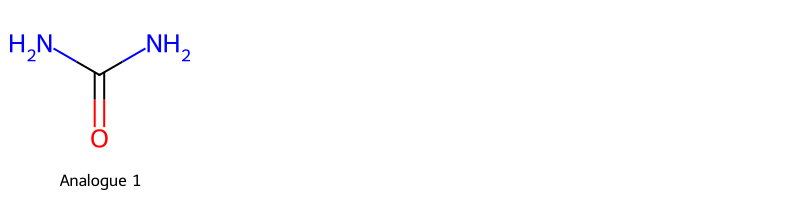

In [ ]:
Draw.MolsToGridImage(get_query_analogues(query_id), molsPerRow=4, legends=[f"Analogue {i+1}" for i in range(N)])